In [62]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tqdm

In [76]:
class KMeans:
    def __init__(self, k, init='random', n_init=10, max_iter=300):
        self.k_clusters = k
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.cluster_centers = None

    def _init_cluster_centers(self, xs):
        cc = np.array([])
        if self.init == 'random':
            idx = np.random.choice(range(xs.shape[0]), self.k_clusters, replace=False)
            cc = xs[idx]
        elif self.init == 'k-means++':
            init_idx = np.random.choice(range(xs.shape[0]))
            cc = [init_idx]
            while len(cc) < self.k_clusters:
                squared_distances = np.array(
                    [min(np.linalg.norm(x - xs[c]) for c in cc) for x in xs])
                total_dis = squared_distances.sum()
                prob = squared_distances / total_dis
                cc.append(np.random.choice(range(xs.shape[0]), p=prob))
            cc = xs[cc]
        return cc

    def predict(self, xs, cluster_centers=None):
        cluster_centers = self.cluster_centers if cluster_centers is None else cluster_centers

        # xs.shape: (n, ch), cluster_centers.shape: (k, ch)
        return np.linalg.norm(xs[:, np.newaxis] - cluster_centers[np.newaxis],
                              axis=-1).argmin(axis=-1)

    def _predict_one(self, x, cluster_centers=None):
        cluster_centers = self.cluster_centers if cluster_centers is None else cluster_centers
        return np.linalg.norm(x - cluster_centers, axis=-1).argmin()

    def score(self, cluster_centers, xs):
        distance = np.linalg.norm(xs[:, np.newaxis] - cluster_centers[np.newaxis],
                                   axis=-1).min(axis=-1).sum()

        return distance

    def _update_center(self, cluster_centers, xs):
        idx = self.predict(xs, cluster_centers)
        new_centers = np.array([xs[idx == i].mean(axis=0) for i in range(self.k_clusters)])
        return new_centers

    def fit(self, xs):
        best, best_cc = -1, None
        for _ in range(self.n_init):
            cluster_centers = self._fit_single_run(xs)
            score = self.score(cluster_centers, xs)
            if best == -1 or score < best:
                best, best_cc = score, cluster_centers
        self.cluster_centers = best_cc
        return self

    def _fit_single_run(self, xs):
        epsilon = 1e-5
        cluster_centers = self._init_cluster_centers(xs)
        for _ in tqdm.trange(self.max_iter):
            new_cc = self._update_center(cluster_centers, xs)
            change = [np.linalg.norm(nc - oc) for nc, oc in zip(new_cc, cluster_centers)]
            converge = all(ch < epsilon for ch in change)
            if converge:
                break
            cluster_centers = new_cc
        return cluster_centers


In [77]:
image = cv2.imread('2-image.jpg')
image

array([[[172, 153, 150],
        [160, 141, 138],
        [168, 149, 146],
        ...,
        [168, 151, 148],
        [167, 150, 147],
        [167, 150, 147]],

       [[174, 155, 152],
        [180, 161, 158],
        [184, 165, 162],
        ...,
        [168, 151, 148],
        [167, 150, 147],
        [167, 150, 147]],

       [[166, 147, 144],
        [178, 159, 156],
        [138, 119, 116],
        ...,
        [168, 152, 146],
        [168, 152, 146],
        [167, 151, 145]],

       ...,

       [[ 28,  20,   7],
        [ 28,  20,   7],
        [ 28,  20,   7],
        ...,
        [ 30,  24,  13],
        [ 30,  24,  13],
        [ 30,  24,  13]],

       [[ 28,  20,   7],
        [ 28,  20,   7],
        [ 28,  20,   7],
        ...,
        [ 30,  24,  13],
        [ 30,  24,  13],
        [ 30,  24,  13]],

       [[ 28,  20,   7],
        [ 28,  20,   7],
        [ 28,  20,   7],
        ...,
        [ 30,  24,  13],
        [ 30,  24,  13],
        [ 30,  24,  13]]

In [78]:
flatten_img = image.reshape((-1, 3))
flatten_img

array([[172, 153, 150],
       [160, 141, 138],
       [168, 149, 146],
       ...,
       [ 30,  24,  13],
       [ 30,  24,  13],
       [ 30,  24,  13]], dtype=uint8)

In [82]:
kmeans = KMeans(10)
kmeans.fit(flatten_img)

 35%|███▌      | 106/300 [00:08<00:16, 12.00it/s]


In [42]:
flatten_img[:5]

array([[172, 153, 150],
       [160, 141, 138],
       [168, 149, 146],
       [186, 167, 164],
       [ 86,  67,  64]], dtype=uint8)

In [43]:
flatten_img[:3]

array([[172, 153, 150],
       [160, 141, 138],
       [168, 149, 146]], dtype=uint8)

In [56]:
np.linalg.norm(flatten_img[:5][:, np.newaxis, :] - flatten_img[:4][np.newaxis], axis=-1).argmin(axis=-1)

array([0, 1, 2, 3, 3], dtype=int64)

In [83]:
quantized_image = kmeans.cluster_centers[kmeans.predict(flatten_img)]
quantized_image = quantized_image.reshape(image.shape).astype(np.uint8)
quantized_image

array([[[175, 175, 176],
        [114, 126, 148],
        [175, 175, 176],
        ...,
        [175, 175, 176],
        [175, 175, 176],
        [175, 175, 176]],

       [[175, 175, 176],
        [175, 175, 176],
        [175, 175, 176],
        ...,
        [175, 175, 176],
        [175, 175, 176],
        [175, 175, 176]],

       [[175, 175, 176],
        [175, 175, 176],
        [114, 126, 148],
        ...,
        [175, 175, 176],
        [175, 175, 176],
        [175, 175, 176]],

       ...,

       [[ 36,  29,  20],
        [ 36,  29,  20],
        [ 36,  29,  20],
        ...,
        [ 36,  29,  20],
        [ 36,  29,  20],
        [ 36,  29,  20]],

       [[ 36,  29,  20],
        [ 36,  29,  20],
        [ 36,  29,  20],
        ...,
        [ 36,  29,  20],
        [ 36,  29,  20],
        [ 36,  29,  20]],

       [[ 36,  29,  20],
        [ 36,  29,  20],
        [ 36,  29,  20],
        ...,
        [ 36,  29,  20],
        [ 36,  29,  20],
        [ 36,  29,  20]]

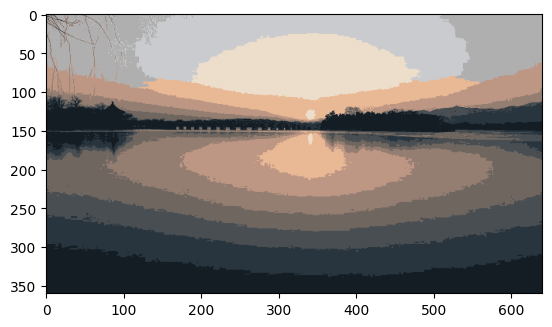

In [86]:
plt.imshow(quantized_image[..., ::-1])